In [28]:
import gym
from gym import spaces
import os
import gc
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import plotting
from DQN_Agent import DQN_Agent
from IDS import IDS_Agent
from UCB import UCB_Agent

In [29]:
class FrozenLakeEnv(gym.Env):
    def __init__(self, grid):
        super(FrozenLakeEnv, self).__init__()
        self.grid = grid
        self.grid_height = len(grid)
        self.grid_width = len(grid[0])
        [self.start_y], [self.start_x] = np.where(np.array(grid) == 'S')
        self.slip_probability = 1/3 # Probability to slip to one side (so the chance of slipping in any direction is 2 times this value)
        assert self.slip_probability <= 1/2
        self.action_space = spaces.Discrete(4)  # Left, Down, Right, Up
        self.observation_space = spaces.Discrete(self.grid_height * self.grid_width)

        self.state_action_count = {}
        for x in range(self.grid_width):
            for y in range(self.grid_height):
                self.state_action_count[(x, y)] = {0: 0, 1: 0, 2: 0, 3: 0}

    def reset(self):
        # Top left corner is 0, 0
        self.state = (self.start_x, self.start_y)
        return self.to_observation(self.state)
    
    def step(self, action):
        self.state_action_count[self.state][action] += 1
        x, y = self.state

        # Define possible actions for each chosen direction
        # Make sure the first action in the array is the action itself (no slip)
        possible_actions = {
                0: [0, 3, 1],  # Left
                1: [1, 0, 2],  # Down
                2: [2, 1, 3],  # Right
                3: [3, 2, 0]   # Up
            }            

        # Choose a random action from the possible actions according to self.slip_probability
        p = self.slip_probability
        action = np.random.choice(possible_actions[action], p=[1-2*p, p, p])
        # print("Actual action", ["left", "down", "right", "up"][action])

        # Move in the chosen direction if its within bounds
        if action == 0 and x > 0:
            x -= 1
        elif action == 1 and y < self.grid_height - 1:
            y += 1
        elif action == 2 and x < self.grid_width - 1:
            x += 1
        elif action == 3 and y > 0:
            y -= 1

        self.state = (x, y)
        reward = 0
        done = False

        # Check state of the cell
        if self.grid[y][x] == 'X':
            reward = -5
            done = True
        elif self.grid[y][x] == 'G':
            reward = 10
            done = True

        return self.to_observation(self.state), reward, done, {}
    
    def get_aleatoric_uncertainty(self):
        # Define possible actions for each chosen direction
        # Make sure the first action in the array is the action itself (no slip)
        possible_actions = {
                0: [0, 3, 1],  # Left
                1: [1, 0, 2],  # Down
                2: [2, 1, 3],  # Right
                3: [3, 2, 0]   # Up
            }  
        variance_map = []

        # Choose a random action from the possible actions according to self.slip_probability
        p = self.slip_probability

        for state in range(self.grid_width*self.grid_height):
            # Move in the chosen direction if its within bounds
            variances = {0:[],1:[],2:[],3:[]}
            # print(state)
            for wanted_action in possible_actions:
                for action in possible_actions[wanted_action]:
                    x, y = state % self.grid_width, state // self.grid_height
                    # print(x,y)
                    if action == 0 and x > 0:
                        x -= 1
                    elif action == 1 and y < self.grid_height - 1:
                        y += 1
                    elif action == 2 and x < self.grid_width - 1:
                        x += 1
                    elif action == 3 and y > 0:
                        y -= 1
                    # Check state of the cell
                    if self.grid[y][x] == 'X':
                        reward = -1
                    elif self.grid[y][x] == 'G':
                        reward = 1
                    else:
                        reward = 0
                    variances[wanted_action].append(reward)
            # print(variances)
            
            for k in variances:
                variances[k] = torch.tensor(np.var(variances[k]))
            variances = torch.stack(tuple(variances[k] for k in variances))
            variance_map.append(variances)

        return variance_map


    def to_observation(self, state):
        x, y = state
        return y * self.grid_width + x

    def render(self):
        grid = np.full((self.grid_height, self.grid_width), ' ')
        for y in range(self.grid_height):
            for x in range(self.grid_width):
                grid[y, x] = self.grid[y][x]
        x, y = self.state
        grid[y, x] = 'A'
        print('\n'.join(' '.join(row) for row in grid))
        print()

def make_frozenlake(grid):
    return FrozenLakeEnv(grid)


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Used for debugging; CUDA related errors shown immediately.

# Seed everything for reproducible results
seed = 2024
np.random.seed(seed)
np.random.default_rng(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

cpu


In [42]:
class Model_TrainTest:
    def __init__(self, seed, device, hyperparams, agent_type='dqn'):
        # Define RL Hyperparameters
        self.train_mode             = hyperparams["train_mode"]
        self.RL_load_path           = hyperparams["RL_load_path"]
        self.save_path              = hyperparams["save_path"]
        self.save_interval          = hyperparams["save_interval"]
        
        self.clip_grad_norm         = hyperparams["clip_grad_norm"]
        self.learning_rate          = hyperparams["learning_rate"]
        self.discount_factor        = hyperparams["discount_factor"]
        self.batch_size             = hyperparams["batch_size"]
        self.update_frequency       = hyperparams["update_frequency"]
        self.max_episodes           = hyperparams["max_episodes"]
        self.max_episode_length     = hyperparams["max_episode_length"]
        self.max_steps              = hyperparams["max_steps"]
        self.render                 = hyperparams["render"]
        
        self.epsilon_max            = hyperparams["epsilon_max"]
        self.epsilon_min            = hyperparams["epsilon_min"]
        self.epsilon_decay          = hyperparams["epsilon_decay"]
        
        self.memory_capacity        = hyperparams["memory_capacity"]
        
        self.num_states             = hyperparams["num_states"]
        # self.map_size               = hyperparams["map_size"]
        self.map                    = hyperparams["map"]
        self.render_fps             = hyperparams["render_fps"]
        
        self.n_bins                 = hyperparams["n_bins"]
        
        self.env = make_frozenlake(self.map)
        self.env.metadata['render_fps'] = self.render_fps # For max frame rate make it 0
        self.agent_type = agent_type
        # Define the agent class
        self.agent = None
        self.reset_agent()
        self.agent_type = agent_type
        self.state_history = []
        self.loss_bins = []

    def state_preprocess(self, state:int, num_states:int):
        """
        Convert an state to a tensor and basically it encodes the state into
        an onehot vector. For example, the return can be something like tensor([0,0,1,0,0])
        which could mean agent is at state 2 from total of 5 states.

        """
        onehot_vector = torch.zeros(num_states, dtype=torch.float32, device=device)
        onehot_vector[state] = 1
        return onehot_vector
    
    
    def reset_agent(self):
        if self.agent_type == 'dqn':
            self.agent = DQN_Agent(env            = self.env,
                                seed              = seed,
                                device            = device,
                                epsilon_max       = self.epsilon_max,
                                epsilon_min       = self.epsilon_min,
                                epsilon_decay     = self.epsilon_decay,
                                clip_grad_norm    = self.clip_grad_norm,
                                learning_rate     = self.learning_rate,
                                discount          = self.discount_factor,
                                memory_capacity   = self.memory_capacity)
        if self.agent_type == 'ucb':
            self.agent = UCB_Agent(env            = self.env,
                                seed              = seed,
                                device            = device,
                                epsilon_max       = self.epsilon_max,
                                epsilon_min       = self.epsilon_min,
                                epsilon_decay     = self.epsilon_decay,
                                clip_grad_norm    = self.clip_grad_norm,
                                learning_rate     = self.learning_rate,
                                discount          = self.discount_factor,
                                memory_capacity   = self.memory_capacity)
        if self.agent_type == 'ids':
            self.agent = IDS_Agent(   env               = self.env,
                                seed              = seed,
                                device            = device,
                                epsilon_max       = self.epsilon_max,
                                epsilon_min       = self.epsilon_min,
                                epsilon_decay     = self.epsilon_decay,
                                clip_grad_norm    = self.clip_grad_norm,
                                learning_rate     = self.learning_rate,
                                discount          = self.discount_factor,
                                memory_capacity   = self.memory_capacity,
                                num_ensembles     = 10)
    
    def run(self, training, agent=None):
        """                
        Reinforcement learning training loop.
        """        
        total_steps = 0
        episode = 0
        self.reward_history = []
        self.episode_length_history = []
        self.environment_steps_history = []
        if not training:
            self.agent = agent
        else:
            self.reset_agent()

        # Training loop over episodes
        while total_steps < self.max_steps and episode < self.max_episodes:
            state = self.env.reset()
            self.state_history.append(state)
            state = self.state_preprocess(state, num_states=self.num_states)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0
                                                
            while not done and not truncation:
                action = self.agent.select_action(state)
                next_state, reward, done, truncation = self.env.step(action)
                self.state_history.append(next_state)
                next_state = self.state_preprocess(next_state, num_states=self.num_states)

                if(training):
                    self.agent.replay_memory.store(state, action, next_state, reward, done)

                    # if len(self.agent.replay_memory) > self.batch_size and sum(self.reward_history) > 0: This was the original but since we have a negative reward so the sum doesn't work the same way anymore
                    if len(self.agent.replay_memory) > self.batch_size:
                        self.agent.learn(self.batch_size, (done or truncation))

                        # Update target-network weights
                        if total_steps % self.update_frequency == 0:
                            self.agent.hard_update()

                    # Penalize if the episode is truncated (BAD PRACTICE, NON MARKOVIAN)
                    if not truncation and step_size >= self.max_episode_length:
                        truncation = True
                        reward = -10
                
                state = next_state
                episode_reward += reward
                step_size +=1
                            
            # Appends for tracking history
            total_steps += step_size
            self.reward_history.append(episode_reward) # episode reward    
            self.episode_length_history.append(step_size) # episode length
            self.environment_steps_history.append(total_steps) # total steps
            episode += 1
                                                                           
            # Decay epsilon at the end of each episode
            self.agent.update_epsilon()
            
            result = (f"Episode: {episode}, "
                      f"Total Steps: {total_steps}, "
                      f"Raw Reward: {episode_reward:.2f}, ")
        return self.agent
                                                                    

    # def test(self, max_episodes):
    #     """
    #     Reinforcement learning policy evaluation.
    #     """
    #
    #     # # Load the weights of the test_network
    #     # self.agent.main_network.load_state_dict(torch.load(self.RL_load_path))
    #     # self.agent.main_network.eval()
    #
    #     # Testing loop over episodes
    #     for episode in range(1, max_episodes+1):
    #         state = self.env.reset()
    #         done = False
    #         truncation = False
    #         step_size = 0
    #         episode_reward = 0
    #
    #         while not done and not truncation:
    #             state = self.state_preprocess(state, num_states=self.num_states)
    #             action = self.agent.select_action(state)
    #             next_state, reward, done, truncation, _ = self.env.step(action)
    #
    #             state = next_state
    #             episode_reward += reward
    #             step_size += 1
    #
    #         # Print log
    #         result = (f"Episode: {episode}, "
    #                   f"Steps: {step_size:}, "
    #                   f"Reward: {episode_reward:.2f}, ")
    #         print(result)
    
    def plot_training(self):
        plotting.plot_binned_line_with_std([self.environment_steps_history], [self.reward_history], self.n_bins, y_label="Reward", title=f"Reward over time ({self.agent_type})", plot_individuals=False)
        plotting.plot_binned_line_with_std([self.environment_steps_history], [self.episode_length_history], self.n_bins, y_label="Episode Length", title=f"Episode Length over time ({self.agent_type})", plot_individuals=False)
        print(len(self.environment_steps_history[3:]), len(self.agent.loss_history))
        plotting.plot_binned_line_with_std([self.environment_steps_history[3:]], [self.agent.loss_history], self.n_bins, y_label="Loss", title=f"Loss over time ({self.agent_type})", plot_individuals=False)

    def get_plotting_data(self):
        padded_loss_history = self.agent.loss_history
        if len(padded_loss_history) == 0:
            padded_loss_history = []
        else:
            while len(padded_loss_history) < len(self.environment_steps_history):
                padded_loss_history = [padded_loss_history[0]] + padded_loss_history
        return self.environment_steps_history, self.reward_history, self.episode_length_history, padded_loss_history, self.state_history

In [32]:
no_aleatoric_uncertainty_3x3 = [
    ['S', '.', '.'],
    ['.', '.', '.'],
    ['.', '.', 'G']
]

safe_3x3 = [
    ['S', 'X', '.'],
    ['.', '.', '.'],
    ['.', '.', 'G']
]

long_safe_4x3 = [
    ['S', 'X', 'G'],
    ['.', 'X', '.'],
    ['.', 'X', '.'],
    ['.', '.', '.']
]

short_unsafe_long_safe_4x3 = [
    ['S', 'X', 'G'],
    ['.', '.', '.'],
    ['.', 'X', '.'],
    ['.', '.', '.']
]

unsafe_path_safe_area_3x4 = [
    ['S', '.', 'X', '.'],
    ['.', '.', '.', '.'],
    ['.', '.', 'X', 'G']
]

random_test_4x4 = [
    ['S', '.', 'X'],
    ['.', '.', '.'],
    ['.', 'X', '.'],
    ['.', '.', 'G']
]

In [46]:
def plot_results(env_steps_histories, eps_length_histories, map_state_histories, agent_reward_histories, agent_loss_histories, state_map, agents, n_bins):
    if train_mode:
        plotting.plot_binned_line_with_std(env_steps_histories, agent_reward_histories, n_bins, y_label="Reward", title="Reward over time", plot_individuals=True)
        plotting.plot_binned_line_with_std(env_steps_histories, eps_length_histories, n_bins, y_label="Episode Length", title="Episode Length over time", plot_individuals=True)
        plotting.plot_binned_line_with_std(env_steps_histories, agent_loss_histories, n_bins, y_label="Loss", title="Loss over time", plot_individuals=True)
    else:
        for i in range(len(map_state_histories)):
            state_table = np.zeros_like(state_map)
            print(agents[i].get_best_actions(state_table, device))
            plotting.plot_grid_statespace(map_state_histories[i], agents[i].get_best_actions(state_table, device), state_map)
        plotting.plot_barchart_rewards(agent_reward_histories, y_label="Reward Counts", title="Bar Chart of Unique Values and Their Corresponding Reward Counts")
        plotting.plot_barchart_episode_length(eps_length_histories, n_bins, y_label='Amount of Finished Runs', title="Bar Chart of Unique Values and Their Corresponding Reward Counts")
        
def run_model(agents):
    DRL = Model_TrainTest(seed, device, RL_hyperparams, agent_type=agent_type) # Define the instance
    environment_steps_histories, reward_histories, episode_length_histories, loss_histories, state_histories = [], [], [], [], []
    if train_mode:
        for i in range(2):
            print(i)
            trained_agent = DRL.run(train_mode, None)
            agents.append(trained_agent)
    
            # Save all the data for plotting (plotted in next cell)
            environment_steps_history, reward_history, episode_length_history, loss_history, state_history = DRL.get_plotting_data()
            environment_steps_histories.append(environment_steps_history)
            reward_histories.append(reward_history)
            episode_length_histories.append(episode_length_history)
            loss_histories.append(loss_history)
            state_histories.append(state_history)
    else:
        for agent in agents:
            DRL.run(train_mode, agent)
            
            # Save all the data for plotting (plotted in next cell)
            environment_steps_history, reward_history, episode_length_history, loss_history, state_history = DRL.get_plotting_data()
            environment_steps_histories.append(environment_steps_history)
            reward_histories.append(reward_history)
            episode_length_histories.append(episode_length_history)
            loss_histories.append(loss_history)
            state_histories.append(state_history)
    return environment_steps_histories, reward_histories, episode_length_histories, loss_histories, state_histories, agents

In [34]:
# Parameters:
train_mode = True
agent_type = 'dqn'               # 'dqn', 'ucb' or 'ids'

render = not train_mode
# map_size = 4 # 4x4 or 8x8 (outdated)
map_mame = "long_safe_4x3"
state_map = long_safe_4x3
RL_hyperparams = {
    "train_mode"            : train_mode,
    "RL_load_path"          : f'./level_stats/{map_mame}/final_weights' + '_' + '3000' + '.pth',
    "save_path"             : f'./level_stats/{map_mame}/final_weights',
    "save_interval"         : 500,
    
    "clip_grad_norm"        : 3,
    "learning_rate"         : 6e-4,
    "discount_factor"       : 0.93,
    "batch_size"            : 32,
    "update_frequency"      : 10,
    "max_episodes"          : 100000           if train_mode else 200,
    "max_steps"             : 30000,
    "max_episode_length"    : 1000,
    "render"                : render,
    
    "epsilon_max"           : 0.999         if train_mode else -1,
    "epsilon_min"           : 0.01,
    "epsilon_decay"         : 0.998,
    
    "memory_capacity"       : 4_000        if train_mode else 0,
        
    # "map_size"              : map_size,
    "num_states"            : len(state_map) * len(state_map[0]),    # 3 rows in your example
    "map"                   : state_map,
    "render_fps"            : 6,
    "n_bins"                : 100
    }

agent_histories = []
environment_steps_histories, reward_histories, episode_length_histories, loss_histories, state_histories, agent_histories = run_model(agent_histories)

0
1


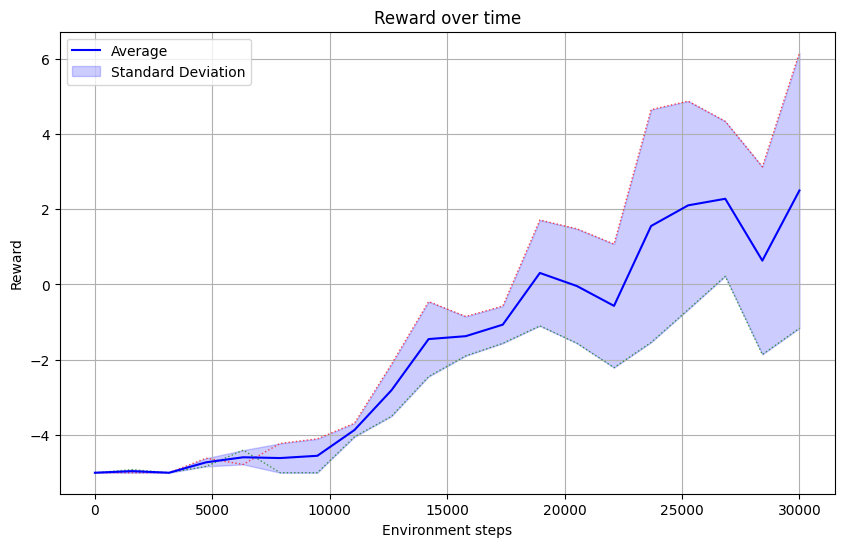

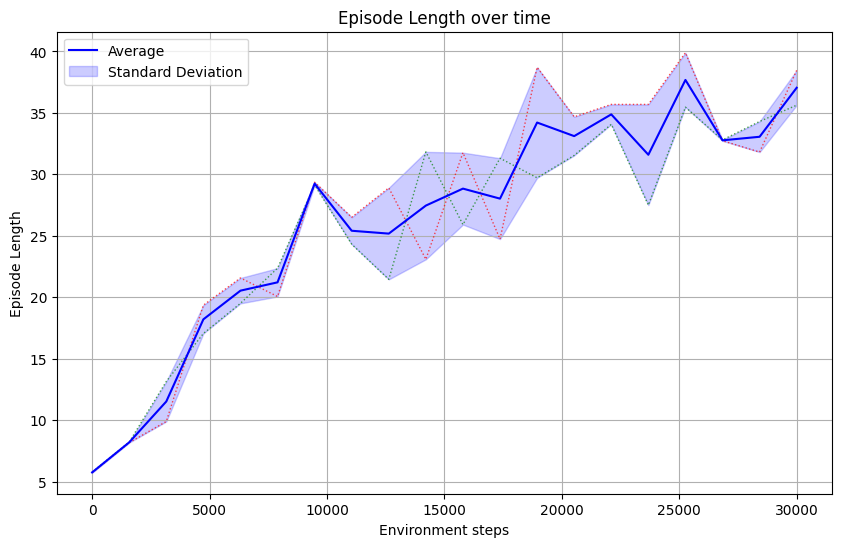

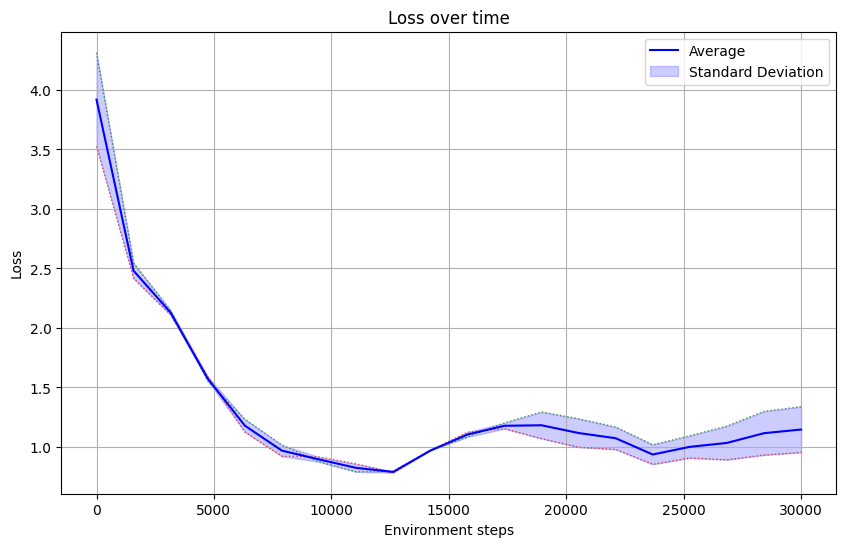

In [35]:
n_bins = 20
plot_results(environment_steps_histories, episode_length_histories, state_histories, reward_histories, loss_histories, state_map, agent_histories, n_bins)

In [44]:
# Parameters:
train_mode = False

render = not train_mode
RL_hyperparams = {
    "train_mode"            : train_mode,
    "RL_load_path"          : f'./level_stats/{map_mame}/final_weights' + '_' + '3000' + '.pth',
    "save_path"             : f'./level_stats/{map_mame}/final_weights',
    "save_interval"         : 500,
    
    "clip_grad_norm"        : 3,
    "learning_rate"         : 6e-4,
    "discount_factor"       : 0.93,
    "batch_size"            : 32,
    "update_frequency"      : 10,
    "max_episodes"          : 100000           if train_mode else 200,
    "max_steps"             : 100000,
    "max_episode_length"    : 1000,
    "render"                : render,
    
    "epsilon_max"           : 0.999         if train_mode else -1,
    "epsilon_min"           : 0.01,
    "epsilon_decay"         : 0.998,
    
    "memory_capacity"       : 4_000        if train_mode else 0,
        
    # "map_size"              : map_size,
    "num_states"            : len(state_map) * len(state_map[0]),    # 3 rows in your example
    "map"                   : state_map,
    "render_fps"            : 6,
    "n_bins"                : 100
    }

# Run
environment_steps_histories, reward_histories, episode_length_histories, loss_histories, state_histories, agent_histories = run_model(agent_histories)

i
i


[['0' '2' '0']
 ['0' '0' '1']
 ['0' '0' '0']
 ['0' '1' '2']]
[['0' '0' '2']
 ['0' '2' '2']
 ['0' '0' '0']
 ['0' '2' '2']]


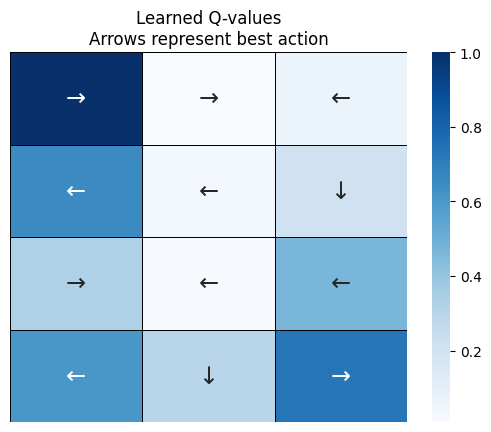

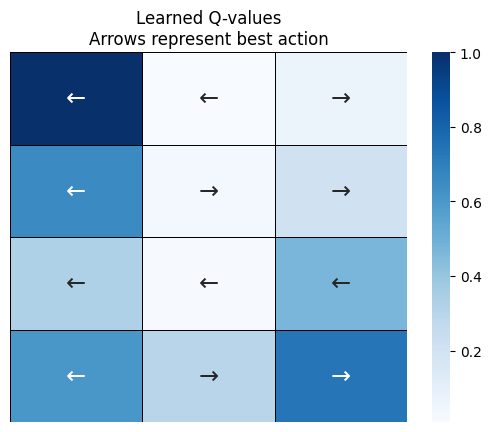

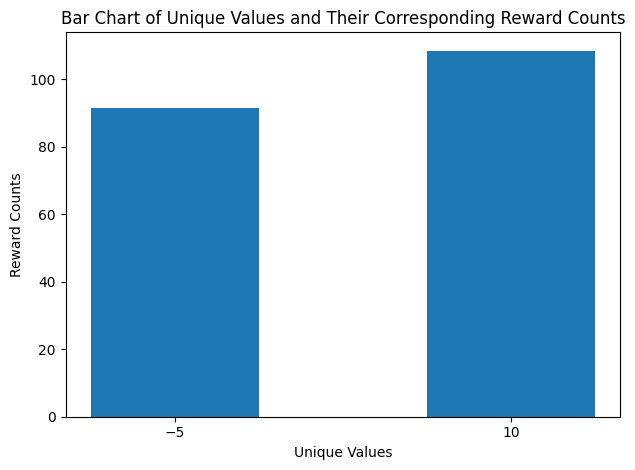

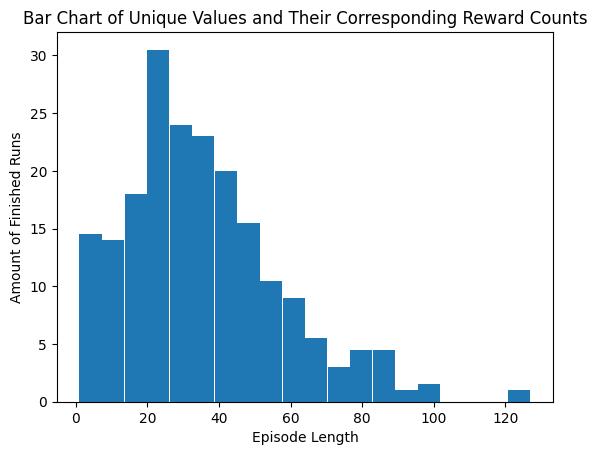

In [47]:
n_bins = 20
plot_results(environment_steps_histories, episode_length_histories, state_histories, reward_histories, loss_histories, state_map, agent_histories, n_bins)